In [1]:
import numpy as np
import math
import heapq
import ray
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from gym.spaces import Discrete, MultiDiscrete, Dict
from ray import tune, air
from ray.rllib.algorithms.ppo import PPOConfig
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ray.tune.registry import register_env
from ray.rllib.utils.pre_checks.env import check_env

In [17]:
# define the custom routing grid environment

# action space encoding
    # 0 - > move up
    # 1 - > move down
    # 2 - > move right
    # 3 - > move left
# state (observation) space encoding
    # state[0:1] = current agent position
    # state[2:3] = current goal position
    # state[4:7] = capacities of the four neighboring edges of the current agent position. Namely, up, right, down, and left


class RtGridEnv(MultiAgentEnv):
    def __init__(self, length:int, width:int, nets:list, macros:list, edge_capacity:np.ndarray, max_step:int):
        """
        Args:
            length (int): length of the canvas
            width (int): width of the canvas
            nets (list): a list of nets to be routed
            macros (list): a list of macros that has been placed on the canvas by placement
        """
        #super().__init__()
        self.length = length
        self.width = width
        self.nets = nets
        self.n_nets = len(self.nets)
        self.macros = macros
        self.initial_capacity = edge_capacity.copy()
        self.initial_capacity.setflags(write=False)
        self.edge_capacity = edge_capacity.copy()
        self.max_capacity = np.max(self.edge_capacity) + 1 # plus one to account for the behavior of gym.MultiDiscrete
        self.max_step = max_step
        self.step_counter = 0 # counts the number of steps elapsed for the current episode
        
        self.agents_id = []
        for i in range(self.n_nets):
            self.agents_id.append("agent_{}".format(i))
        self._agent_ids = set(self.agents_id)
        self.state = {}
        self.agent_position = {}
        self.goal_position = {}
        self.change_pin_flag = self.reset_flags({})
        self.done_flag = self.reset_flags({})
        #print("change pin flags ", self.change_pin_flag)
        # the done flag needs an additional "__all__" key to indicate all agents are done
        self.done_flag["__all__"] = False
        #print("done flags ", self.done_flag)
        self.pin_counter = {}
        self.reset_pin_counters()
        self.path_x = self.generate_path(self.nets)
        self.path_y = self.generate_path(self.nets)
        #print(self.path_x)
        self.decomposed_nets = {}
        for i in range(self.n_nets): 
            self.decomposed_nets[self.agents_id[i]] = self.prim_mst(self.nets[i])
        
        # initialize the agent to route the first 2-pin net decomposed from the first multi-pin net
        for agent_id in self.agents_id:
            self.update_positions(agent_id)
            self.update_path(agent_id)
        #print(self.agent_position)
        #print(self.goal_position)
        # initialize the path lists
        #for agent_id in self.agents_id:
            #self.update_path(agent_id)
        #print(self.path_x)
        #print(self.path_y)
        # define the action and the observation space
        '''self.action_space = Dict()
        self.observation_space = Dict()
        for agent_id in self.agents_id:
            self.action_space[agent_id] = Discrete(4)
            self.observation_space[agent_id] = MultiDiscrete(
                [
                    self.length, 
                    self.width, 
                    self.length, 
                    self.width, 
                    self.max_capacity, 
                    self.max_capacity, 
                    self.max_capacity, 
                    self.max_capacity
                ]
            )'''
        self.action_space = Discrete(4)
        self.observation_space = MultiDiscrete([self.length, self.width, self.length, self.width, self.max_capacity, self.max_capacity, self.max_capacity, self.max_capacity])

    def update_positions(self, agent_id:str):
        """
        Update the agent position with the starting pin of the next 2-pin net.
        Update the goal position with the new goal.
        """
        self.agent_position[agent_id] = np.array(self.decomposed_nets[agent_id]['u'][self.pin_counter[agent_id]])
        self.goal_position[agent_id] = np.array(self.decomposed_nets[agent_id]['v'][self.pin_counter[agent_id]])

    def update_path(self, agent_id:str):
        """Update the path agent has traveled."""
        self.path_x[agent_id][self.pin_counter[agent_id]].append(self.agent_position[agent_id][0])
        self.path_y[agent_id][self.pin_counter[agent_id]].append(self.agent_position[agent_id][1])

    def reset_pin_counters(self):
        """Set the pin counter of each agent to 0."""
        for i in range(self.n_nets):
            self.pin_counter[self.agents_id[i]] = 0
    
    def reset_flags(self, flags:dict):
        for i in range(self.n_nets):
            flags[self.agents_id[i]] = False

        return flags

    def generate_path(self, nets:list):
        """Generate the list data structure to hold the path traveled by the agent."""
        path = {}
        for i in range(len(nets)):
            path[self.agents_id[i]] = []
            for j in range(len(nets[i])-1):
                path[self.agents_id[i]].append([])

        return path

    def prim_mst(self, pins):
        """
        Compute the Minimum Spanning Tree (MST) using Prim's algorithm.

        Args:
            pins (list): List of (x, y) coordinates representing the pin locations.

        Returns:
            dict: a dictionary containing the vertices of all the edges in the MST

        Note:
            - The pins list should contain at least two points.
        """

        def euclidean_distance(p1, p2):
            """
            Compute the Euclidean distance between two points.

            Args:
                p1 (tuple): First point (x, y) coordinates.
                p2 (tuple): Second point (x, y) coordinates.

            Returns:
                float: Euclidean distance between the two points.
            """
            x1, y1 = p1
            x2, y2 = p2
            return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        
        distances = {}
        for i in range(len(pins)):
            for j in range(i+1, len(pins)):
                p1 = pins[i]
                p2 = pins[j]
                distances[(i, j)] = euclidean_distance(p1, p2)
                distances[(j, i)] = distances[(i, j)]  # Add symmetric distance
        
        # Initialize
        num_pins = len(pins)
        visited = [False] * num_pins
        mst_u = []
        mst_v = []
        start_vertex = 0
        visited[start_vertex] = True
        
        # Create a priority queue
        pq = []
        
        # Mark the initial vertex as visited
        for i in range(num_pins):
            if i != start_vertex:
                heapq.heappush(pq, (distances[(start_vertex, i)], start_vertex, i))
        
        # Update the priority queue and perform Prim's algorithm
        while pq:
            if (len(mst_u) == len(pins) -1): # for n pins, the MST should at most have n-1 edges
                break

            weight, u, v = heapq.heappop(pq)
            
            if visited[v]:
                #print(f"Skipping edge: {weight} - {u} - {v}")
                continue
            
            # Prim's algorithm iteration
            visited[v] = True
            mst_u.append(pins[u])
            mst_v.append(pins[v])
            
            for i in range(num_pins):
                if not visited[i]:
                    heapq.heappush(pq, (distances[(v, i)], v, i))
        
        mst = {'u':mst_u,'v':mst_v}

        return mst
    
    def update_capacity(self, agent_position:np.ndarray, action:int):
        """
        Update the edge capacities after taking an action
        """

        # reduce the capacity of the current node
        self.edge_capacity[agent_position[0]][agent_position[1]][action] += -1

        # reduce the capacity of the next node's corresponding edge
        new_node = self.compute_new_position(agent_position, action)
        corresponding_edge = (action + 2) % 4
        self.edge_capacity[new_node[0]][new_node[1]][corresponding_edge] += -1
        
    def compute_new_position(self, agent_position:np.ndarray, action:int):
        """
        Compute new agent positions
        """
        if action == 0: # up
            new_position = (agent_position[0], agent_position[1]+1)
        elif action == 1: # right
            new_position = (agent_position[0]+1, agent_position[1])
        elif action == 2: # down
            new_position = (agent_position[0], agent_position[1]-1)
        elif action == 3: # left
            new_position = (agent_position[0]-1, agent_position[1])
        
        return new_position
    
    def step(self, action:dict):
        def check_move_validity(agent_position:np.ndarray, action:int):
            """
            Check whether a move is valid by checking:
            (1) the edge the move is about to use has capacity greater than 0
            (2) the position after the move is not within macro regions
            (3) the position after the move in within in the routing canvas
            Returns True if the move is valid, False if invalid
            """
            # capacity of the 4 neighboring edges of the current agent position
            node_capacity = self.edge_capacity[agent_position[0]][agent_position[1]]

            new_position = self.compute_new_position(agent_position, action)

            macro_flag = new_position not in self.macros
            bound_flag = new_position[0] in range(self.length) and new_position[1] in range(self.width)
            capacity_flag = node_capacity[action] > 0

            valid = macro_flag and bound_flag and capacity_flag

            return valid
        
        # extract all the active agents in this time step
        active_agent = list(action.keys())
        # used for computing observations
        initial_active_agent = list(action.keys())
        #print("active agent ", active_agent)
        reward = {}

        # if we have reached our maximum time step, set the all done flag
        self.step_counter += 1
        if self.step_counter >= self.max_step:
            for agent_id in active_agent:
                reward[agent_id] = -1
            self.done_flag["__all__"] = True
            #print("reward ", reward)
            #print("done flags ", self.done_flag)
            observation = {agent: self.state[agent] for agent in initial_active_agent if agent in self.state}
            return observation, reward, self.done_flag, {}
        
        # update pins for those agents in need
        # Only agents that have the change pin flag set to True AND are active, will be updated
        pin_flag_agents = [key for key, value in self.change_pin_flag.items() if value]
        pin_flag_agents = list(set(active_agent).intersection(set(pin_flag_agents)))
        for agent_id in pin_flag_agents:
            #print(agent_id)
            self.update_positions(agent_id)
            self.update_path(agent_id)
            reward[agent_id] = 0
            self.change_pin_flag[agent_id] = False
            self.state[agent_id] = np.concatenate([
                self.agent_position[agent_id], 
                self.goal_position[agent_id], 
                self.edge_capacity[self.agent_position[agent_id][0]][self.agent_position[agent_id][1]]
                ])
            active_agent.remove(agent_id) # de-active agents that undergoes pin-upgrading, such that they won't be unintentionally accessed

        for agent_id in active_agent:
            if check_move_validity(self.agent_position[agent_id], action[agent_id]):
                self.update_capacity(self.agent_position[agent_id], action[agent_id])
                self.agent_position[agent_id] = np.array(list(self.compute_new_position(self.agent_position[agent_id], action[agent_id])))
                self.update_path(agent_id)

            if np.array_equal(self.agent_position[agent_id], self.goal_position[agent_id]):
                reward[agent_id] = 10
                self.update_counters(agent_id)
            else:
                reward[agent_id] = -1
            
            self.state[agent_id] = np.concatenate([
                self.agent_position[agent_id], 
                self.goal_position[agent_id], 
                self.edge_capacity[self.agent_position[agent_id][0]][self.agent_position[agent_id][1]]
                ])
        # if all agents are done, set the __all__ flag
        self.done_flag["__all__"] = all(self.done_flag[agent_key] for agent_key in self.done_flag if agent_key.startswith('agent_'))
        # only return observations for active agents
        observation = {agent: self.state[agent] for agent in initial_active_agent if agent in self.state}
        
        return observation, reward, self.done_flag, {}
        #print("state ", self.state)
        #print("change pin flag ", self.change_pin_flag)
        #print("reward ", reward)

    def update_counters(self, agent_id:str):
        # one 2-pin net within one multi-pin net is done
        self.pin_counter[agent_id] += 1
        self.change_pin_flag[agent_id] = True
        net_id = int(agent_id.split("_")[1])

        if self.pin_counter[agent_id] == len(self.nets[net_id]) - 1:
            # this agent is done, it has routed all the pins
            #self.pin_counter[agent_id] -= 1
            self.change_pin_flag[agent_id] = False
            self.done_flag[agent_id] = True
    
    def render(self):
        """Plot the agent's path."""
        colors = cm.rainbow(np.linspace(0, 1, len(self.agents_id)))
        i = 0
        for agent_id in self.agents_id:
            color = colors[i]
            i += 1
            for j in range(len(self.path_x[agent_id])):
                plt.plot(self.path_x[agent_id][j], self.path_y[agent_id][j], color = color)

        # plot the pins
        i = 0
        for net in self.nets:
            color = colors[i]
            x_coords, y_coords = zip(*net)
            plt.scatter(x_coords, y_coords, color = color)
            i += 1
        
        # plot the macro pins
        for point in self.macros:
            x, y = point
            plt.scatter(x,y, color='black')

        # set the labels and title
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Nets')

        # set the x and y axis ticks
        plt.xticks(range(0, self.length))
        plt.yticks(range(0, self.width))

        # set the grid
        plt.grid(color='blue', linestyle='--', linewidth=0.5)

        # show the plot
        plt.show()

    def heatmap(self):
        """Generate the horizontal and vertical edge usage heat maps."""
        horizontal_edge_index = 1 # indices for the up and right edge
        vertical_edge_index = 0
        shape = self.edge_capacity.shape
        horizontal_usage = self.edge_capacity[0:shape[0]-1, :, [horizontal_edge_index]].squeeze().transpose()
        vertical_usage = self.edge_capacity[:, 0:shape[1]-1, [vertical_edge_index]].squeeze().transpose()
        ticks = np.arange(0,self.max_capacity)
        
        plt.figure()
        sns.heatmap(horizontal_usage, annot=True, cmap="Reds", square=True, cbar_kws={"ticks":ticks})
        plt.gca().invert_yaxis()
        plt.title("Horizontal Heat Map")
        plt.show()

        plt.figure()
        sns.heatmap(vertical_usage, annot=True, cmap="Reds", square=True, cbar_kws={"ticks":ticks})
        plt.gca().invert_yaxis()
        plt.title("Vertical Heat Map")
        plt.show()

    def reset(self):
        #print("RESETTING...")
        self.reset_pin_counters()
        #print("pin counters ", self.pin_counter)
        self.step_counter = 0
        self.change_pin_flag = self.reset_flags(self.change_pin_flag)
        self.done_flag = self.reset_flags(self.done_flag)
        self.done_flag["__all__"] = False
        #print("change pin flags ", self.change_pin_flag)
        #print("done flags ", self.done_flag)
        self.edge_capacity = self.initial_capacity.copy()
        self.path_x = self.generate_path(self.nets)
        self.path_y = self.generate_path(self.nets)
        #print("path x ", self.path_x)
        #print("path y ", self.path_y)
        for agent_id in self.agents_id:
            self.update_positions(agent_id)
            self.update_path(agent_id)
        #for agent_id in self.agents_id:
            #self.update_path(agent_id)
        #print("agent positions ", self.agent_position)
        #print("goal positions ", self.goal_position)
        #print("path x ", self.path_x)
        #print("path y ", self.path_y)
        for agent_id in self.agents_id:
            individual_state = np.concatenate([
                self.agent_position[agent_id], 
                self.goal_position[agent_id], 
                self.edge_capacity[self.agent_position[agent_id][0]][self.agent_position[agent_id][1]]
                ])
            self.state[agent_id] = individual_state
        
        return self.state


In [18]:
nets = [[(2,1), (2,3), (3,3)],[(1,4), (3,4), (3,2)], [(1,5), (1,2)], [(0,5), (3,5), (2,2)], [(3,1), (4,3)], [(0,0), (5,0), (5,5)]]
macros = [(0,2), (0,4)]
length = 6
width = 6
n_nets = len(nets)
edge_capacity = np.full((length,width,4),n_nets)
max_step = 1000

env = RtGridEnv(length, width, nets, macros, edge_capacity, max_step)
obs = env.reset()
print(obs)

'''env.step_counter = 999
env.pin_counter = {"agent_0":2, "agent_1":1, "agent_2":0, "agent_3":0, "agent_4":0, "agent_5":0}
env.change_pin_flag = {"agent_0":True, "agent_1":True, "agent_2":False, "agent_3":False, "agent_4":False, "agent_5":False}
action = {"agent_0":0, "agent_1":1, "agent_2":2, "agent_3":3, "agent_4":0}
env.step(action)'''

{'agent_0': array([2, 1, 2, 3, 6, 6, 6, 6]), 'agent_1': array([1, 4, 3, 4, 6, 6, 6, 6]), 'agent_2': array([1, 5, 1, 2, 6, 6, 6, 6]), 'agent_3': array([0, 5, 3, 5, 6, 6, 6, 6]), 'agent_4': array([3, 1, 4, 3, 6, 6, 6, 6]), 'agent_5': array([0, 0, 5, 0, 6, 6, 6, 6])}


'env.step_counter = 999\nenv.pin_counter = {"agent_0":2, "agent_1":1, "agent_2":0, "agent_3":0, "agent_4":0, "agent_5":0}\nenv.change_pin_flag = {"agent_0":True, "agent_1":True, "agent_2":False, "agent_3":False, "agent_4":False, "agent_5":False}\naction = {"agent_0":0, "agent_1":1, "agent_2":2, "agent_3":3, "agent_4":0}\nenv.step(action)'

In [5]:
action = {"agent_0":0, "agent_1":1, "agent_2":2, "agent_3":1, "agent_4":1, "agent_5":1}
obs, reward, done, info = env.step(action)
print("obs ", obs)
print("reward", reward)
print("done", done)



obs  {'agent_0': array([2, 2, 2, 3, 6, 6, 5, 6]), 'agent_1': array([2, 4, 3, 4, 6, 6, 6, 5]), 'agent_2': array([1, 4, 1, 2, 5, 5, 6, 6]), 'agent_3': array([1, 5, 3, 5, 6, 6, 5, 5]), 'agent_4': array([4, 1, 4, 3, 6, 6, 6, 5]), 'agent_5': array([1, 0, 5, 0, 6, 6, 6, 5])}
reward {'agent_0': -1, 'agent_1': -1, 'agent_2': -1, 'agent_3': -1, 'agent_4': -1, 'agent_5': -1}
done {'agent_0': False, 'agent_1': False, 'agent_2': False, 'agent_3': False, 'agent_4': False, 'agent_5': False, '__all__': False}


In [6]:
action = {"agent_0":0, "agent_1":1, "agent_2":2, "agent_3":1, "agent_4":0, "agent_5":1}
obs, reward, done, info = env.step(action)
print("obs ", obs)
print("reward", reward)
print("done", done)

obs  {'agent_0': array([2, 3, 2, 3, 6, 6, 5, 6]), 'agent_1': array([3, 4, 3, 4, 6, 6, 6, 5]), 'agent_2': array([1, 3, 1, 2, 5, 6, 6, 6]), 'agent_3': array([2, 5, 3, 5, 6, 6, 6, 5]), 'agent_4': array([4, 2, 4, 3, 6, 6, 5, 6]), 'agent_5': array([2, 0, 5, 0, 6, 6, 6, 5])}
reward {'agent_0': 1000, 'agent_1': 1000, 'agent_2': -1, 'agent_3': -1, 'agent_4': -1, 'agent_5': -1}
done {'agent_0': False, 'agent_1': False, 'agent_2': False, 'agent_3': False, 'agent_4': False, 'agent_5': False, '__all__': False}


In [7]:
action = {"agent_0":0, "agent_1":1, "agent_2":2, "agent_3":1, "agent_4":0, "agent_5":1}
obs, reward, done, info = env.step(action)
print("obs ", obs)
print("reward", reward)
print("done", done)

obs  {'agent_0': array([2, 3, 3, 3, 6, 6, 5, 6]), 'agent_1': array([3, 4, 3, 2, 6, 6, 6, 5]), 'agent_2': array([1, 2, 1, 2, 5, 6, 6, 6]), 'agent_3': array([3, 5, 3, 5, 6, 6, 6, 5]), 'agent_4': array([4, 3, 4, 3, 6, 6, 5, 6]), 'agent_5': array([3, 0, 5, 0, 6, 6, 6, 5])}
reward {'agent_1': 0, 'agent_0': 0, 'agent_2': 1000, 'agent_3': 1000, 'agent_4': 1000, 'agent_5': -1}
done {'agent_0': False, 'agent_1': False, 'agent_2': True, 'agent_3': False, 'agent_4': True, 'agent_5': False, '__all__': False}


In [8]:
action = {"agent_0":1, "agent_1":2,  "agent_3":1, "agent_5":1}
obs, reward, done, info = env.step(action)
print("obs ", obs)
print("reward", reward)
print("done", done)

obs  {'agent_0': array([3, 3, 3, 3, 6, 6, 6, 5]), 'agent_1': array([3, 3, 3, 2, 5, 6, 6, 5]), 'agent_3': array([3, 5, 2, 2, 6, 6, 6, 5]), 'agent_5': array([4, 0, 5, 0, 6, 6, 6, 5])}
reward {'agent_3': 0, 'agent_0': 1000, 'agent_1': -1, 'agent_5': -1}
done {'agent_0': True, 'agent_1': False, 'agent_2': True, 'agent_3': False, 'agent_4': True, 'agent_5': False, '__all__': False}


In [9]:
action = { "agent_1":2,  "agent_3":3, "agent_5":1}
obs, reward, done, info = env.step(action)
print("obs ", obs)
print("reward", reward)
print("done", done)

obs  {'agent_1': array([3, 2, 3, 2, 5, 6, 6, 6]), 'agent_3': array([2, 5, 2, 2, 6, 4, 6, 5]), 'agent_5': array([5, 0, 5, 0, 6, 6, 6, 5])}
reward {'agent_1': 1000, 'agent_3': -1, 'agent_5': 1000}
done {'agent_0': True, 'agent_1': True, 'agent_2': True, 'agent_3': False, 'agent_4': True, 'agent_5': False, '__all__': False}


In [10]:
action = {"agent_3":2, "agent_5":2}
obs, reward, done, info = env.step(action)
print("obs ", obs)
print("reward", reward)
print("done", done)

obs  {'agent_3': array([2, 4, 2, 2, 5, 5, 6, 5]), 'agent_5': array([5, 0, 5, 5, 6, 6, 6, 5])}
reward {'agent_5': 0, 'agent_3': -1}
done {'agent_0': True, 'agent_1': True, 'agent_2': True, 'agent_3': False, 'agent_4': True, 'agent_5': False, '__all__': False}


In [11]:
action = {"agent_3":2, "agent_5":1}
obs, reward, done, info = env.step(action)
print("obs ", obs)
print("reward", reward)
print("done", done)

obs  {'agent_3': array([2, 3, 2, 2, 5, 5, 5, 6]), 'agent_5': array([5, 0, 5, 5, 6, 6, 6, 5])}
reward {'agent_3': -1, 'agent_5': -1}
done {'agent_0': True, 'agent_1': True, 'agent_2': True, 'agent_3': False, 'agent_4': True, 'agent_5': False, '__all__': False}


In [12]:
action = {"agent_3":2, "agent_5":0}
obs, reward, done, info = env.step(action)
print("obs ", obs)
print("reward", reward)
print("done", done)

obs  {'agent_3': array([2, 2, 2, 2, 4, 6, 5, 6]), 'agent_5': array([5, 1, 5, 5, 6, 6, 5, 6])}
reward {'agent_3': 1000, 'agent_5': -1}
done {'agent_0': True, 'agent_1': True, 'agent_2': True, 'agent_3': True, 'agent_4': True, 'agent_5': False, '__all__': False}


In [13]:
action = {"agent_5":0}
obs, reward, done, info = env.step(action)
print("obs ", obs)
print("reward", reward)
print("done", done)

obs  {'agent_5': array([5, 2, 5, 5, 6, 6, 5, 6])}
reward {'agent_5': -1}
done {'agent_0': True, 'agent_1': True, 'agent_2': True, 'agent_3': True, 'agent_4': True, 'agent_5': False, '__all__': False}


In [14]:
print(env.path_x)
print(env.path_y)

{'agent_0': [[2, 2, 2], [2, 3]], 'agent_1': [[1, 2, 3], [3, 3, 3]], 'agent_2': [[1, 1, 1, 1]], 'agent_3': [[0, 1, 2, 3], [3, 2, 2, 2, 2]], 'agent_4': [[3, 4, 4, 4]], 'agent_5': [[0, 1, 2, 3, 4, 5], [5, 5, 5]]}
{'agent_0': [[1, 2, 3], [3, 3]], 'agent_1': [[4, 4, 4], [4, 3, 2]], 'agent_2': [[5, 4, 3, 2]], 'agent_3': [[5, 5, 5, 5], [5, 5, 4, 3, 2]], 'agent_4': [[1, 1, 2, 3]], 'agent_5': [[0, 0, 0, 0, 0, 0], [0, 1, 2]]}


In [35]:
#nets = [[(2,1), (2,3), (3,3), (4,2)],[(1,4), (3,4), (4,4)]]
#macros = [(0,2), (1,2)]
nets = [[(2,1), (2,3), (3,3)],[(1,4), (3,4), (3,2)], [(1,5), (1,2)], [(0,5), (3,5), (2,2)], [(3,1), (4,3)], [(0,0), (5,0), (5,5)]]
macros = [(0,2), (0,4)]
length = 6
width = 6
n_nets = len(nets)
edge_capacity = np.full((length,width,4),n_nets)
max_step = 1000

env = RtGridEnv(length, width, nets, macros, edge_capacity, max_step)
num_episodes = 1

for ep in range(num_episodes):
    #total_reward = 0
    obs = env.reset()
    done = {}
    for i in range(5):
        done["agent_{}".format(i)] = False
    done["__all__"] = False
    while True:
        action = env.action_space.sample()
        # only agents that are not done will be provided an action
        action = {agent: action[agent] for agent in done if not done[agent] and agent != "__all__"}
        new_obs, reward, done, info = env.step(action)
        #print(new_obs)
        #total_reward += reward
            
        #print(f"episode: {ep}")
        #print(f"obs: {new_obs}, reward: {total_reward}, done: {done}")
        if done["__all__"]:
            print(reward)
            break
    #print(total_reward)
    env.render()
    env.heatmap()
    #print(env.edge_capacity)

TypeError: 'int' object is not subscriptable

In [3]:
ray.init(ignore_reinit_error=True)

2023-08-04 11:11:11,874	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.10.9
Ray version:,2.2.0


In [19]:
# check the environment
register_env("routing_grid_env", lambda config: RtGridEnv(length, width, nets, macros, edge_capacity, max_step))
env = RtGridEnv(length, width, nets, macros, edge_capacity, max_step)

print("checking environment ...")
try:
    check_env(env)
    print("All checks passed. No errors found.")
except:
    print("failed")
    print(check_env(env))

checking environment ...
All checks passed. No errors found.


In [20]:
#from ray.rllib.agents.ppo import PPOTrainer
config = (
    PPOConfig()
    .environment(env = "routing_grid_env")
    .rollouts(num_rollout_workers=2)
    .evaluation(evaluation_interval=15, evaluation_duration=5, evaluation_num_workers=1)
    .training(lr=0.00005, gamma=0.99)
)
#trainer = PPOTrainer(config=config)
algo = config.build()

(RolloutWorker pid=34171) 2023-08-04 11:37:23,573	WARNING env.py:247 -- Your MultiAgentEnv <RtGridEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
(RolloutWorker pid=34271) 2023-08-04 11:37:27,685	WARNING env.py:247 -- Your MultiAgentEnv <RtGridEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
2023-08-04 11:37:28,199	WARNING util.py:66 -- Install gputil for GPU system monitoring.


In [21]:
# train the new agent using RLlib.train() in a loop
num_iterations = 40
rewards = []
checkpoint_dir = "saved_runs/trial/"

for i in range(num_iterations):
    result = algo.train()
    rewards.append(result["episode_reward_mean"])

    # save a checkpoint and evaluate the policy at the end of the training
    if (i==num_iterations-1):
        checkpoint_file = algo.save(checkpoint_dir)
        eval_result = algo.evaluate()
print(rewards)
#print(eval_result)
#print(result)

[-4061.25, -3792.125, -3867.0, -3796.5, -3834.95, -3916.5, -3827.8928571428573, -3638.53125, -3598.25, -3420.475, -3318.659090909091, -3215.875, -3167.75, -3056.9285714285716, -3054.2833333333333, -3010.59375, -2937.794117647059, -2890.8055555555557, -2771.4415584415583, -2646.144578313253, -2569.0898876404494, -2404.6020408163267, -2038.54, -1667.6, -1543.76, -1205.69, -821.31, -618.49, -199.62, -30.66, 42.38793103448276, 29.78, 53.32335329341317, 65.7, 72.48805460750853, 71.38271604938272, 77.27678571428571, 78.09037900874635, 79.02824858757062, 79.26685393258427]


{'agent_0': [[2, 2, 2], [2, 3]], 'agent_1': [[1, 2, 3], [3, 3, 3]], 'agent_2': [[1, 1, 1, 1]], 'agent_3': [[0, 1, 2, 3], [3, 3, 3, 3, 2]], 'agent_4': [[3, 3, 3, 4]], 'agent_5': [[0, 1, 2, 3, 4, 5], [5, 5, 5, 5, 5, 5]]}
{'agent_0': [[1, 2, 3], [3, 3]], 'agent_1': [[4, 4, 4], [4, 3, 2]], 'agent_2': [[5, 4, 3, 2]], 'agent_3': [[5, 5, 5, 5], [5, 4, 3, 2, 2]], 'agent_4': [[1, 2, 3, 3]], 'agent_5': [[0, 0, 0, 0, 0, 0], [0, 1, 2, 3, 4, 5]]}


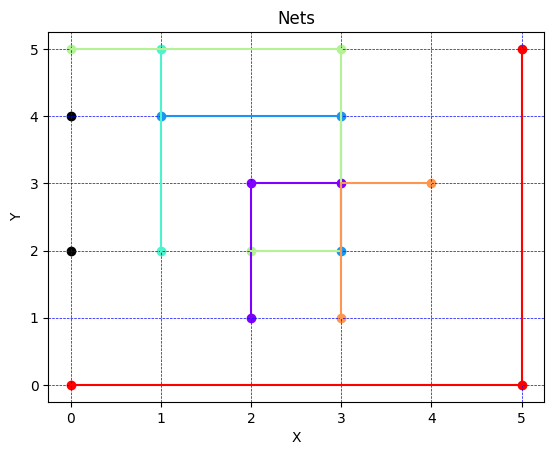

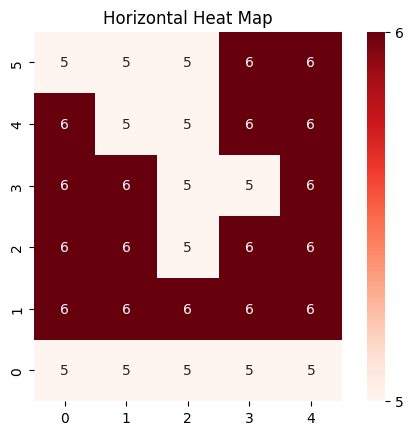

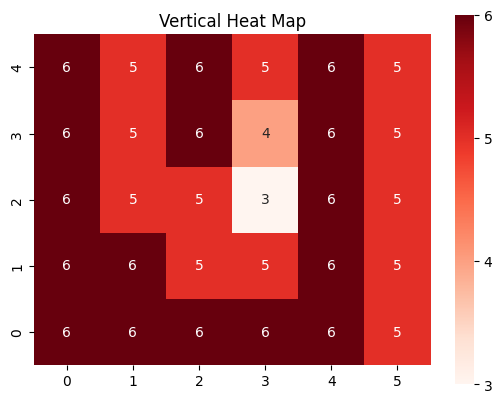

{'agent_0': [[2, 2, 2], [2, 3]], 'agent_1': [[1, 2, 3], [3, 3, 3]], 'agent_2': [[1, 1, 1, 1]], 'agent_3': [[0, 1, 2, 3], [3, 3, 3, 3, 2]], 'agent_4': [[3, 3, 3, 4]], 'agent_5': [[0, 1, 2, 3, 4, 5], [5, 5, 5, 5, 5, 5]]}
{'agent_0': [[1, 2, 3], [3, 3]], 'agent_1': [[4, 4, 4], [4, 3, 2]], 'agent_2': [[5, 4, 3, 2]], 'agent_3': [[5, 5, 5, 5], [5, 4, 3, 2, 2]], 'agent_4': [[1, 2, 3, 3]], 'agent_5': [[0, 0, 0, 0, 0, 0], [0, 1, 2, 3, 4, 5]]}


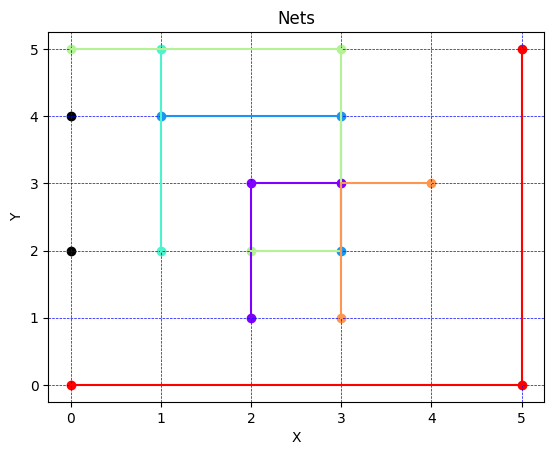

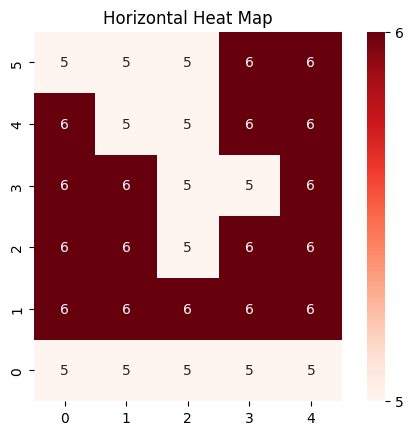

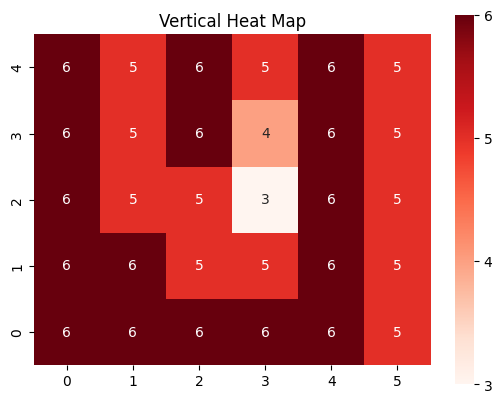

{'agent_0': [[2, 2, 2], [2, 3]], 'agent_1': [[1, 2, 3], [3, 3, 3]], 'agent_2': [[1, 1, 1, 1]], 'agent_3': [[0, 1, 2, 3], [3, 3, 3, 3, 2]], 'agent_4': [[3, 3, 3, 4]], 'agent_5': [[0, 1, 2, 3, 4, 5], [5, 5, 5, 5, 5, 5]]}
{'agent_0': [[1, 2, 3], [3, 3]], 'agent_1': [[4, 4, 4], [4, 3, 2]], 'agent_2': [[5, 4, 3, 2]], 'agent_3': [[5, 5, 5, 5], [5, 4, 3, 2, 2]], 'agent_4': [[1, 2, 3, 3]], 'agent_5': [[0, 0, 0, 0, 0, 0], [0, 1, 2, 3, 4, 5]]}


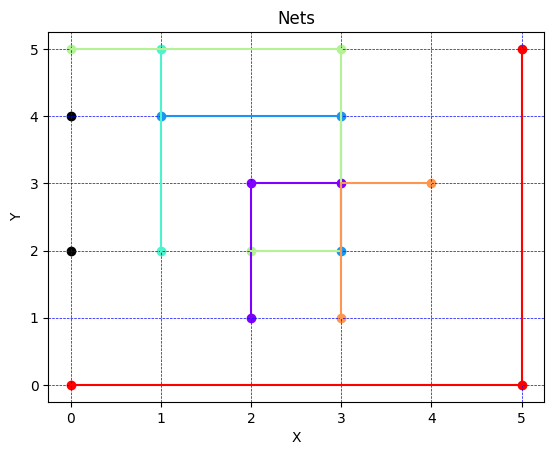

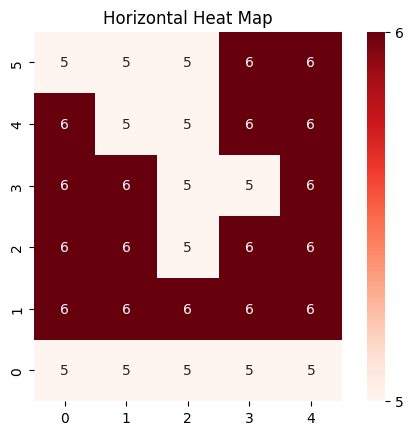

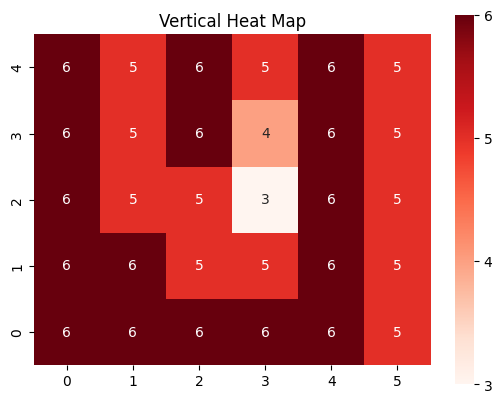

In [22]:
num_episodes = 3
for ep in range(num_episodes):
    #total_reward = 0
    obs = env.reset()
    done = {}
    for i in range(5):
        done["agent_{}".format(i)] = False
    done["__all__"] = False
    while True:
        action = algo.compute_actions(observations=obs, explore=False)
        # only agents that are not done will be provided an action
        action = {agent: action[agent] for agent in done if not done[agent] and agent != "__all__"}
        new_obs, reward, done, info = env.step(action)
        #print(new_obs)
        #total_reward += reward
            
        #print(f"episode: {ep}")
        #print(f"obs: {new_obs}, reward: {total_reward}, done: {done}")
        if done["__all__"]:
            #print(reward)
            break
    #print(total_reward)
    print(env.path_x)
    print(env.path_y)
    env.render()
    env.heatmap()
    #print(env.edge_capacity)

In [ ]:
stop_criteria = dict(time_total_s = 120)
tune.Tuner(
        config2.algo_class,
        run_config=air.RunConfig(
            stop=stop_criteria,
            checkpoint_config=air.CheckpointConfig(
                checkpoint_frequency=10,
            ),
        ),
        param_space=config2.to_dict(),
    ).fit()

(PPO pid=37988) 2023-08-03 18:56:01,792	WARNING algorithm_config.py:488 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
(PPO pid=37988) 2023-08-03 18:56:01,793	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
(PPO pid=37988) 2023-08-03 18:56:02,418	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-08-03 18:56:26,723	ERROR trial_runner.py:1088 -- Trial PPO_routing_grid_env_0eb91_00000: Error processing event.
ray.exceptions.RayTaskError(TypeError): ray::PPO.train() (pid=37988, ip=10.0.0.81, repr=PPO)
  File "/home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise 

Trial name,date,experiment_id,hostname,node_ip,pid,timestamp,trial_id
PPO_routing_grid_env_0eb91_00000,2023-08-03_18-56-26,ee357a1115d24dfb9f28c0392d23759a,brucexi2,10.0.0.81,37988,1691114186,default


(PPO pid=37988) 2023-08-03 18:56:26,707	INFO trainable.py:172 -- Trainable.setup took 24.290 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=37988) 2023-08-03 18:56:26,707	WARNING util.py:66 -- Install gputil for GPU system monitoring.
(PPO pid=37988) 2023-08-03 18:56:26,714	ERROR actor_manager.py:486 -- Ray error, taking actor 1 out of service. ray::RolloutWorker.apply() (pid=38042, ip=10.0.0.81, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x7fb4ded43ee0>)
(PPO pid=37988)   File "/home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 183, in apply
(PPO pid=37988)     raise e
(PPO pid=37988)   File "/home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 174, in apply
(PPO pid=37988)     return func(self, *args, **kwargs)
(PPO pid=37988)   File "/home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/rllib